## Deep Learning

> Antonopoulos Ilias (p3352004) <br />
> Ndoja Silva (p3352017) <br />
> MSc Data Science AUEB

## Table of Contents

- [Data Loading](#Data-Loading)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [88]:
import itertools
from ast import literal_eval

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from matplotlib import offsetbox
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer, StandardScaler

In [36]:
print(tf.__version__)

2.8.0


In [37]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


**tip**: Open the Google Colab link for a GPU runtime:

<a href="https://colab.research.google.com/drive/1AbPgkCURGGClAE4RD5617KJDl5Mmhqun?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

### Data Loading

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
test_images.shape

(10000, 28, 28)

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images.
  
The classes are:
  
| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

In [9]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Exploratory Data Analysis

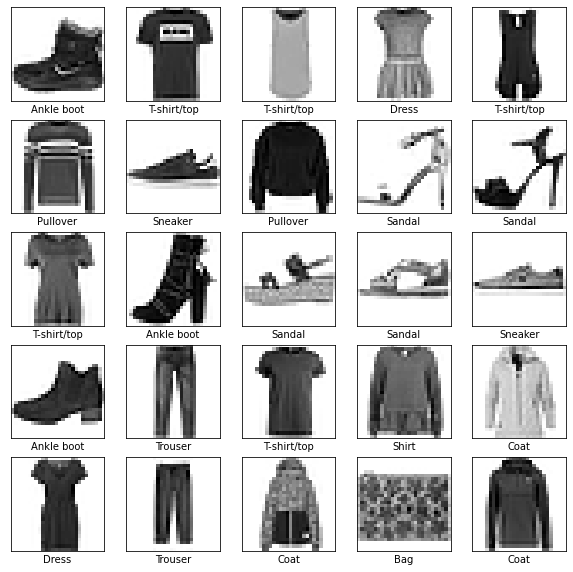

In [11]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [52]:
def visualize_input(img, ax):
    ax.imshow(img, cmap="summer")
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(
                str(round(img[x][y], 2)),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if img[x][y] < thresh else "black",
            )

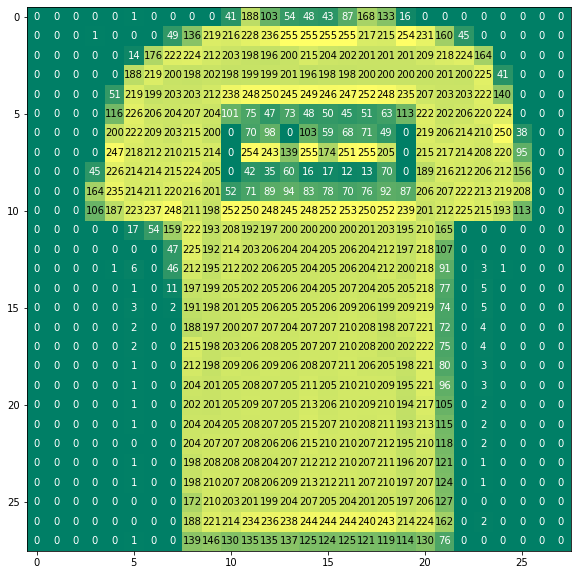

In [53]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
visualize_input(train_images[1], ax)
plt.show()

In [54]:
X_train = train_images.copy().reshape(60000, 784)

y_train = train_labels.copy()

X_train_standardized = StandardScaler().fit_transform(X_train)

X_train_normalized = Normalizer().fit_transform(X_train_standardized)

X_train_tsne = TSNE(n_components=2, init="random", learning_rate=200).fit_transform(
    X_train_normalized
)

In [55]:
colors = [
    "rgb(0,31,63)",
    "rgb(255,133,27)",
    "rgb(255,65,54)",
    "rgb(0,116,217)",
    "rgb(133,20,75)",
    "rgb(57,204,204)",
    "rgb(240,18,190)",
    "rgb(46,204,64)",
    "rgb(1,255,112)",
    "rgb(255,220,0)",
    "rgb(76,114,176)",
    "rgb(85,168,104)",
    "rgb(129,114,178)",
    "rgb(100,181,205)",
]

In [56]:
def plot_tsne_embedding(X_train_tsne, y):
    plt.rcParams["figure.figsize"] = [21, 18]
    for k, i in enumerate(np.unique(y.astype(int))):
        plt.scatter(
            X_train_tsne[y == i, 0],
            X_train_tsne[y == i, 1],
            color="#%02x%02x%02x" % literal_eval(colors[k][3:]),
            label=class_names[k],
        )
    plt.legend()
    plt.show()

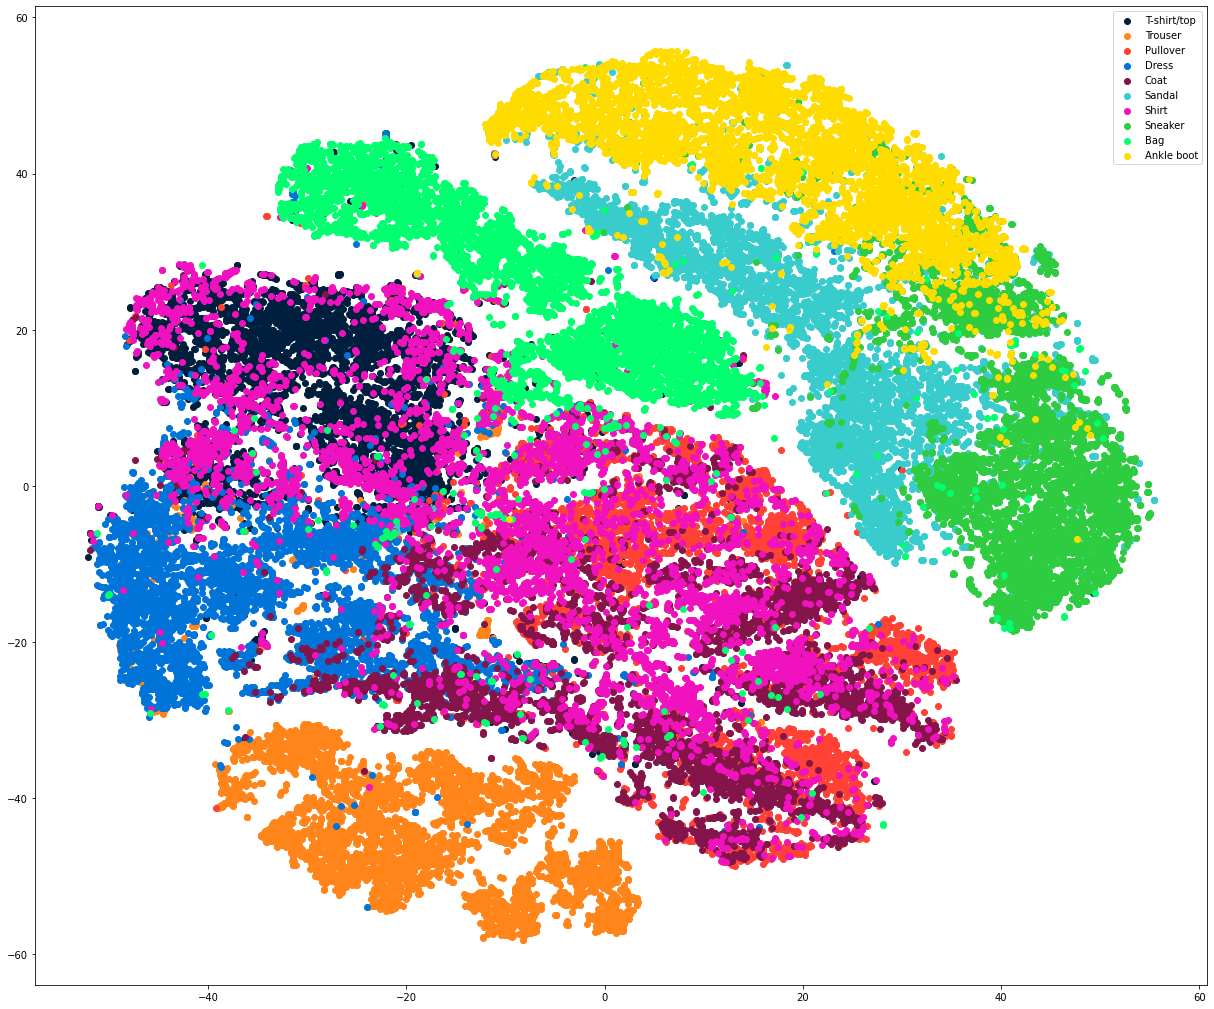

In [57]:
plot_tsne_embedding(X_train_tsne, y_train)

In [58]:
def plot_tsne_embedding_v2(X, X_origin, title=None, dims=[None, 28, 28]):
    dims[0] = X.shape[0]
    X_origin = X_origin.astype(float).reshape(dims)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(
            X[i, 0],
            X[i, 1],
            str(y_train[i]),
            color=plt.cm.Set1(y_train.astype(int)[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    if hasattr(offsetbox, "AnnotationBbox"):
        shown_images = np.array([[1.0, 1.0]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 3e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X_origin[i], cmap=plt.cm.gray_r), X[i]
            )
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

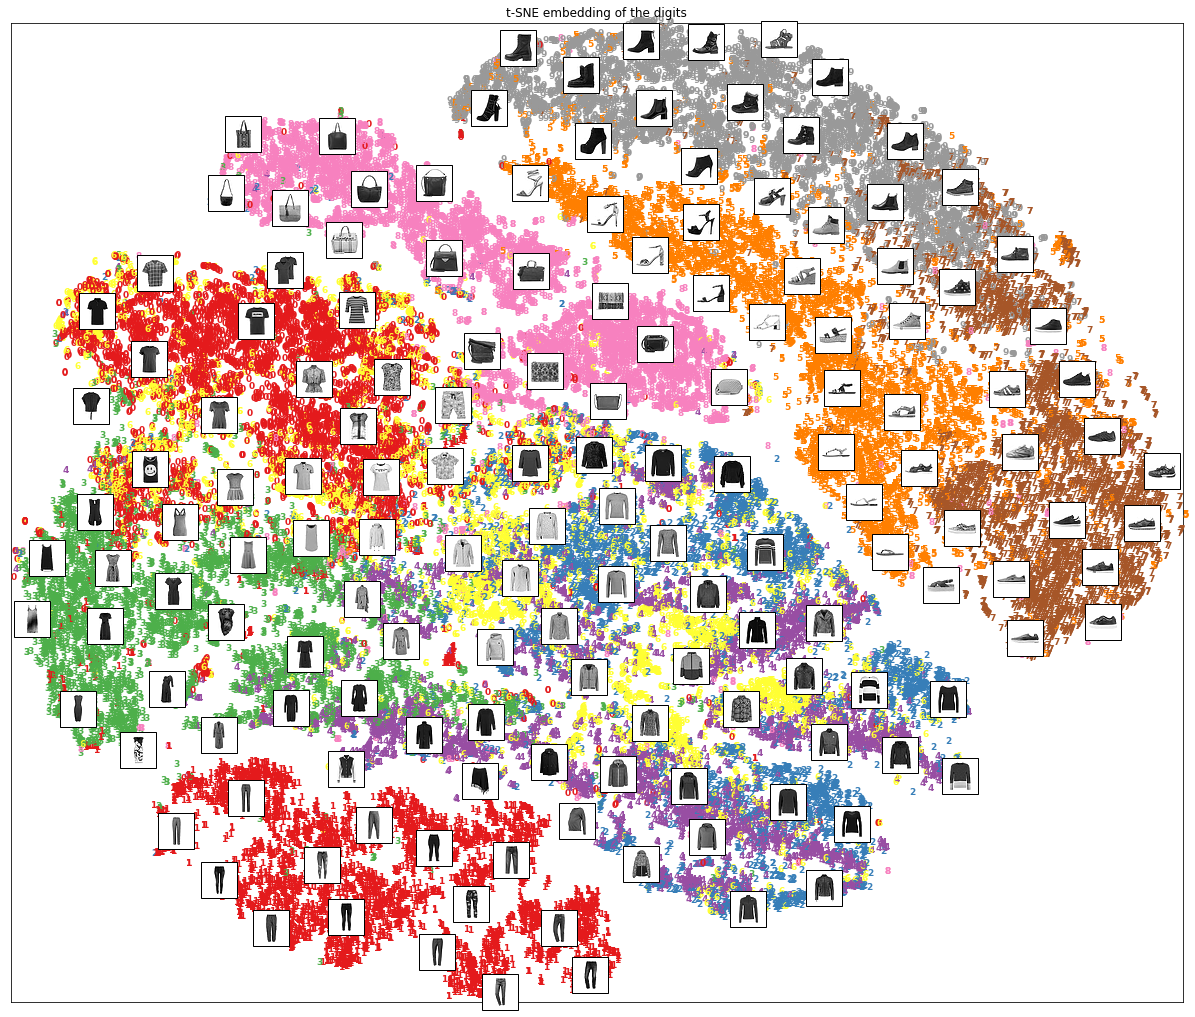

In [59]:
plot_tsne_embedding_v2(X_train_tsne, X_train, "t-SNE embedding of the digits")

### Hyperparameter Tuning

In [31]:
SEED = 123456

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [32]:
def mlp_model_builder(hp):
    """Creates a HyperModel instance (or callable that takes hyperparameters and returns a Model instance)."""
    hp_activation_func = hp.Choice("activation_func", values=["relu", "elu"])
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Rescaling(scale=1.0 / 255))
    model.add(
        tf.keras.layers.Dense(
            units=hp_units, kernel_initializer="glorot_uniform", activation="relu"
        )
    )
    model.add(
        tf.keras.layers.Dense(
            units=10,
            kernel_initializer="glorot_uniform",
        )
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [33]:
# Li, Lisha, and Kevin Jamieson.
# "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization."
# Journal of Machine Learning Research 18 (2018): 1-52.
# https://jmlr.org/papers/v18/16-558.html
tuner = kt.Hyperband(
    mlp_model_builder,
    objective="val_accuracy",
    max_epochs=50,  # the maximum number of epochs to train one model
    seed=SEED,
    directory="hparam-tuning",
    project_name="mlp",
)

In [34]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [38]:
tuner.search(
    train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. \n

Results
=======
|
---- optimal number of units in the first densely-connected layer : {best_hps.get('units')}
|
---- optimal learning rate for the optimizer : {best_hps.get('learning_rate')}
|
---- optimal activation function : {best_hps.get('activation_func')}
"""
)

Trial 90 Complete [00h 02m 56s]
val_accuracy: 0.8880000114440918

Best val_accuracy So Far: 0.8962500095367432
Total elapsed time: 00h 55m 05s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 


Results
|
---- optimal number of units in the first densely-connected layer : 512
|
---- optimal learning rate for the optimizer : 0.0001
|
---- optimal activation function : elu



#### Model Selection

In [39]:
model = tuner.get_best_models(num_models=1)[0]
# summary of best model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 rescaling (Rescaling)       (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [40]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=50, validation_split=0.2)

# keep best epoch
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.6185 - accuracy: 0.7995 - val_loss: 0.4843 - val_accuracy: 0.8359
Epoch 2/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4357 - accuracy: 0.8516 - val_loss: 0.4191 - val_accuracy: 0.8558
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3937 - accuracy: 0.8646 - val_loss: 0.4136 - val_accuracy: 0.8568
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3675 - accuracy: 0.8724 - val_loss: 0.3865 - val_accuracy: 0.8658
Epoch 5/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3484 - accuracy: 0.8785 - val_loss: 0.3631 - val_accuracy: 0.8709
Epoch 6/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3332 - accuracy: 0.8829 - val_loss: 0.3474 - val_accuracy: 0.8802
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3197 - accuracy: 0.8867 - val_loss: 0.3408 - val_accuracy:

In [41]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(
    train_images, train_labels, epochs=best_epoch, validation_split=0.2
)

Epoch 1/45
1500/1500 [==============================] - 8s 5ms/step - loss: 0.6203 - accuracy: 0.7982 - val_loss: 0.4778 - val_accuracy: 0.8378
Epoch 2/45
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4346 - accuracy: 0.8512 - val_loss: 0.4176 - val_accuracy: 0.8557
Epoch 3/45
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3928 - accuracy: 0.8635 - val_loss: 0.4110 - val_accuracy: 0.8571
Epoch 4/45
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3667 - accuracy: 0.8729 - val_loss: 0.3868 - val_accuracy: 0.8637
Epoch 5/45
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3478 - accuracy: 0.8780 - val_loss: 0.3621 - val_accuracy: 0.8708
Epoch 6/45
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3324 - accuracy: 0.8829 - val_loss: 0.3465 - val_accuracy: 0.8794
Epoch 7/45
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3187 - accuracy: 0.8869 - val_loss: 0.3378 - val_accuracy:

### Evaluation

In [42]:
eval_result = hypermodel.evaluate(test_images, test_labels, verbose=3)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.31693148612976074, 0.8956999778747559]


In [43]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use("dark_background")
    plt.rcParams["figure.figsize"] = [15, 8]
    plt.rcParams["font.size"] = 16
    plt.clf()
    for label in hs:
        plt.plot(
            hs[label].history[metric],
            label="{0:s} train {1:s}".format(label, metric),
            linewidth=2,
        )
        plt.plot(
            hs[label].history["val_{0:s}".format(metric)],
            label="{0:s} validation {1:s}".format(label, metric),
            linewidth=2,
        )
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks[0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss" if metric == "loss" else "Accuracy")
    plt.legend()
    plt.show()

Train Loss     : 0.13195
Validation Loss: 0.29749
Test Loss      : 0.31693
---
Train Accuracy     : 0.95625
Validation Accuracy: 0.90117
Test Accuracy      : 0.89570



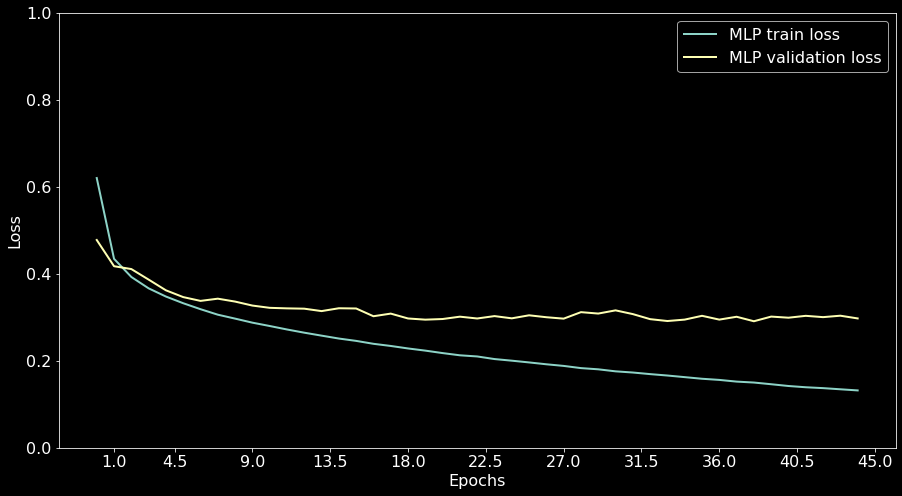

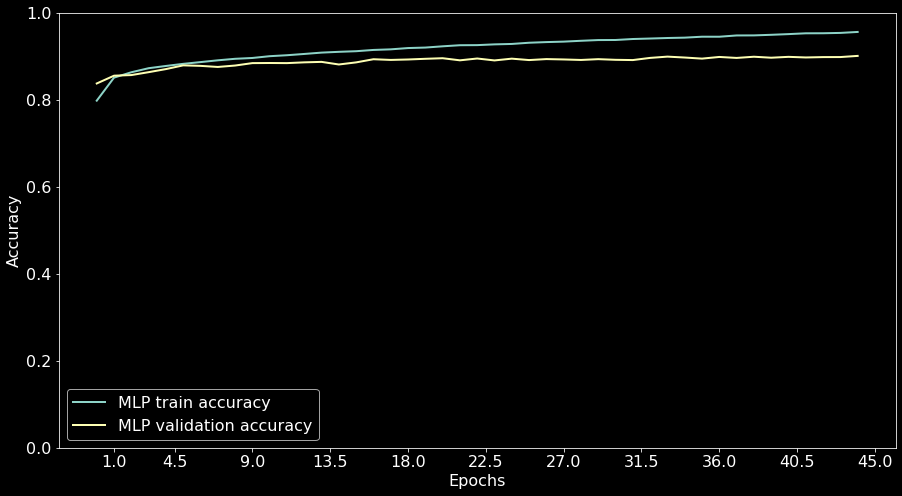

In [59]:
print("Train Loss     : {0:.5f}".format(history.history["loss"][-1]))
print("Validation Loss: {0:.5f}".format(history.history["val_loss"][-1]))
print("Test Loss      : {0:.5f}".format(eval_result[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history["accuracy"][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history["val_accuracy"][-1]))
print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={"MLP": history}, epochs=best_epoch, metric="loss")
plot_history(hs={"MLP": history}, epochs=best_epoch, metric="accuracy")

In [124]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.PuBuGn
):

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = [11, 9]
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

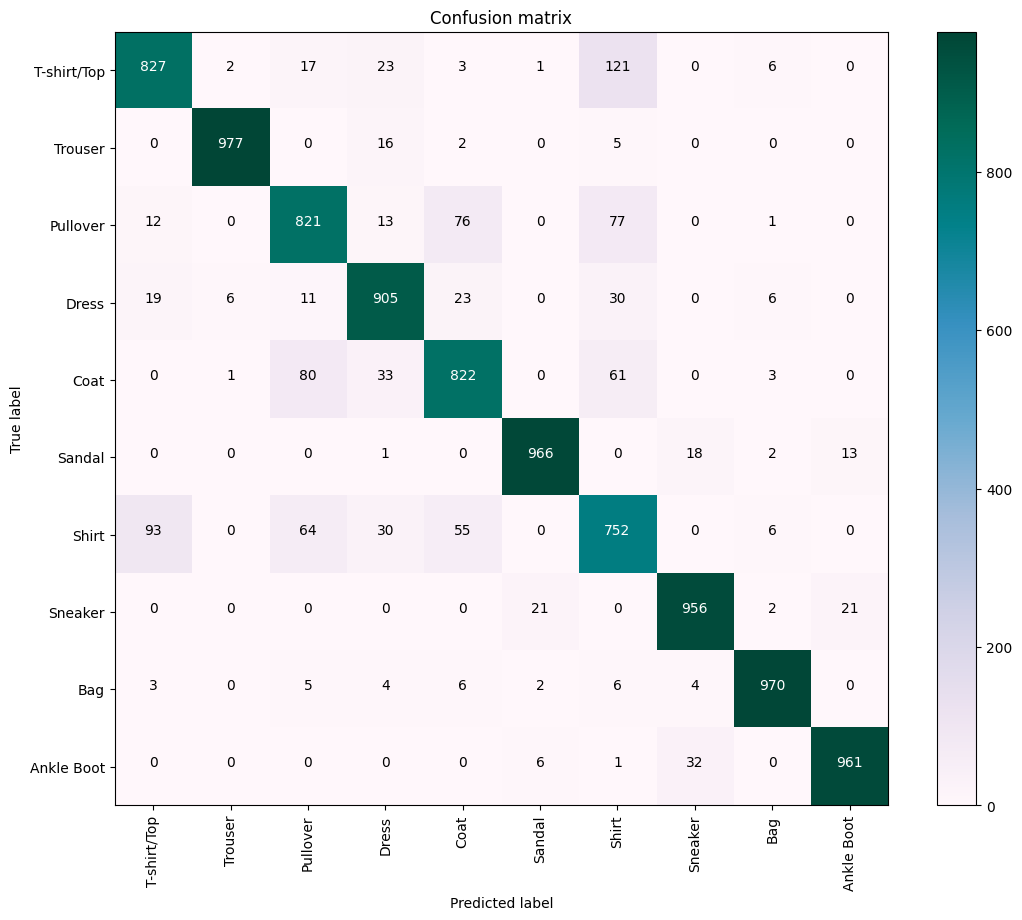

In [125]:
# Predict the values from the validation dataset
Y_pred = hypermodel.predict(test_images)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(
    confusion_mtx,
    classes=[
        "T-shirt/Top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle Boot",
    ],
)

In [127]:
incorrect = []
for i in range(len(test_labels)):
    if not Y_pred_classes[i] == test_labels[i]:
        incorrect.append(i)
    if len(incorrect) == 4:
        break

Text(0.5, 1.0, 'Predicted Label : Pullover\nActual Label : Coat')

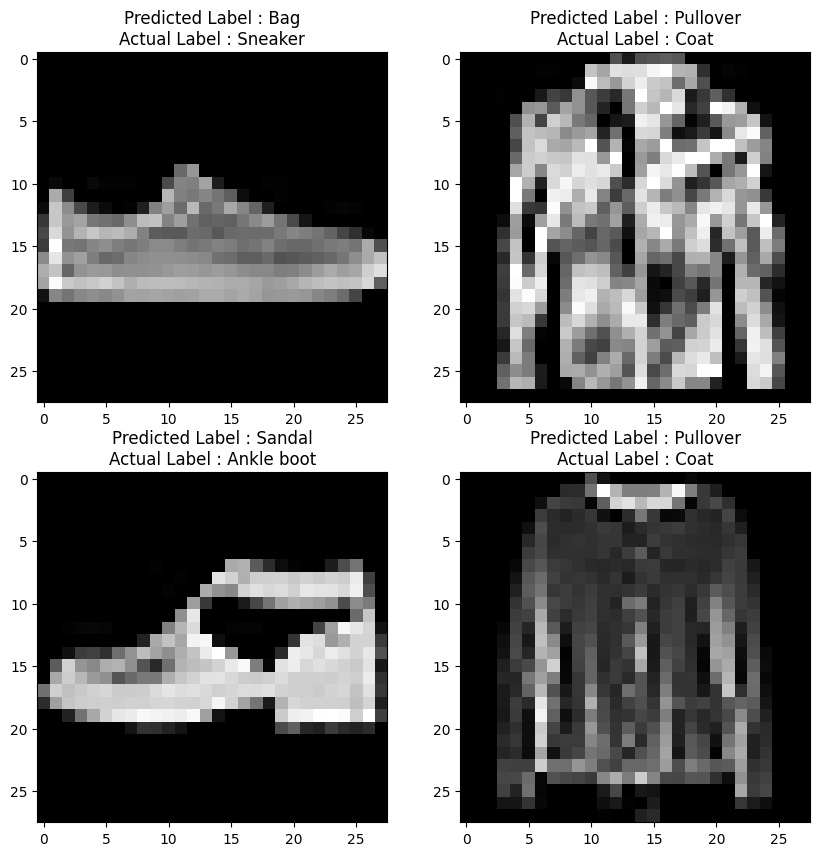

In [137]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.set_size_inches(10, 10)
ax[0, 0].imshow(test_images[incorrect[0]].reshape(28, 28), cmap="gray")

ax[0, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[0]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[0]]]
)
ax[0, 1].imshow(test_images[incorrect[1]].reshape(28, 28), cmap="gray")
ax[0, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[1]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[1]]]
)
ax[1, 0].imshow(test_images[incorrect[2]].reshape(28, 28), cmap="gray")
ax[1, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[2]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[2]]]
)
ax[1, 1].imshow(test_images[incorrect[3]].reshape(28, 28), cmap="gray")
ax[1, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[3]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[3]]]
)